In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.python.layers.core import Dense
from tensorflow.python.ops.rnn_cell_impl import _zero_state_tensors
import tensorflow.contrib.seq2seq.python.ops.attention_wrapper
import tensorflow.contrib.seq2seq.python.ops.beam_search_decoder
print('TensorFlow Version: {}'.format(tf.__version__))

TensorFlow Version: 1.9.0


## Sample Data 

In [3]:
import re
import pprint
from collections import Counter


# maximum length of input and target sentences including paddings
enc_sentence_length = 10
dec_sentence_length = 10

# Batch_size: 2
input_batches = [
    ['Hi What is your name?', 'Nice to meet you!'],
    ['Which programming language do you use?', 'See you later.'],
    ['Where do you live?', 'What is your major?'],
    ['What do you want to drink?', 'What is your favorite beer?']]

target_batches = [
    ['Hi this is Jaemin.', 'Nice to meet you too!'],
    ['I like Python.', 'Bye Bye.'],
    ['I live in Seoul, South Korea.', 'I study industrial engineering.'],
    ['Beer please!', 'Leffe brown!']]

all_input_sentences = []
for input_batch in input_batches:
    all_input_sentences.extend(input_batch)
    
all_target_sentences = []
for target_batch in target_batches:
    all_target_sentences.extend(target_batch)
    
def tokenizer(sentence):
    tokens = re.findall(r"[\w]+|[^\s\w]", sentence)
    return tokens

_START_ = "_GO_"
_PAD_ = "_PAD_"
_END_ = "_END_"

def build_vocab(sentences, max_vocab_size=None):
    word_counter = Counter()
    vocab = dict()
    reverse_vocab = dict()
    
    for sentence in sentences:
        tokens = tokenizer(sentence)
        word_counter.update(tokens)
        
    if max_vocab_size is None:
        max_vocab_size = len(word_counter)
    
    vocab[_START_] = 0
    vocab[_PAD_] = 1
    vocab[_END_] = 2
    vocab_idx = 3
    for key, value in word_counter.most_common(max_vocab_size):
            vocab[key] = vocab_idx
            vocab_idx += 1
            
    for key, value in vocab.items():
        reverse_vocab[value] = key
            
    return vocab, reverse_vocab, max_vocab_size

vocab,reverse_vocab,max_vocab_size = build_vocab(all_input_sentences+all_target_sentences)

def token2idx(word, vocab):
    return vocab[word]

def sent2idx(sent, vocab=vocab, max_sentence_length=enc_sentence_length, is_target=False):
    tokens = tokenizer(sent)
    current_length = len(tokens)
    pad_length = max_sentence_length - current_length
    if is_target:
        return [0] + [token2idx(token, vocab) for token in tokens] + [2] + [1] * (pad_length-1), current_length + 1
    else:
        return [token2idx(token, vocab) for token in tokens] + [1] * pad_length, current_length

def idx2token(idx, reverse_vocab):
    return reverse_vocab[idx]

def idx2sent(indices, reverse_vocab=reverse_vocab):
    return " ".join([idx2token(idx, reverse_vocab) for idx in indices])

# Enc Example
print('Hi What is your name?')
print(sent2idx('Hi What is your name?'))

# Dec Example
print('Hi this is Jaemin.')
print(sent2idx('Hi this is Jaemin.', max_sentence_length=dec_sentence_length, is_target=True))

idx2sent([0, 16, 41, 7, 36, 3, 2, 1, 1, 1, 1])

Hi What is your name?
([16, 6, 7, 9, 39, 5, 1, 1, 1, 1], 6)
Hi this is Jaemin.
([0, 16, 41, 7, 36, 3, 2, 1, 1, 1, 1], 6)


'_GO_ Hi this is Jaemin . _END_ _PAD_ _PAD_ _PAD_ _PAD_'

In [24]:
def batch(inputs, max_sequence_length=None):
    """
    Args:
        inputs:
            list of sentences (integer lists)
        max_sequence_length:
            integer specifying how large should `max_time` dimension be.
            If None, maximum sequence length would be used
    
    Outputs:
        inputs_time_major:
            input sentences transformed into time-major matrix 
            (shape [max_time, batch_size]) padded with 0s
        sequence_lengths:
            batch-sized list of integers specifying amount of active 
            time steps in each input sequence
    """
    
    sequence_lengths = [len(seq) for seq in inputs]
    batch_size = len(inputs)
    
    if max_sequence_length is None:
        max_sequence_length = max(sequence_lengths)
    
    inputs_batch_major = np.zeros(shape=[batch_size, max_sequence_length], dtype=np.int32) # == PAD
    
    for i, seq in enumerate(inputs):
        for j, element in enumerate(seq):
            inputs_batch_major[i, j] = element

    # [batch_size, max_time] -> [max_time, batch_size]
    inputs_time_major = inputs_batch_major.swapaxes(0, 1)

    #return inputs_time_major, sequence_lengths
    return inputs_batch_major, sequence_lengths


def random_sequences(length_from, length_to,
                     vocab_lower, vocab_upper,
                     batch_size):
    """ Generates batches of random integer sequences,
        sequence length in [length_from, length_to],
        vocabulary in [vocab_lower, vocab_upper]
    """
    if length_from > length_to:
            raise ValueError('length_from > length_to')

    def random_length():
        if length_from == length_to:
            return length_from
        return np.random.randint(length_from, length_to + 1)
    
    while True:
        yield [
            np.random.randint(low=vocab_lower,
                              high=vocab_upper,
                              size=random_length()).tolist()
            for _ in range(batch_size)
        ]
        
batches = random_sequences(length_from=5, length_to=20,
                           vocab_lower=2, vocab_upper=15,
                           batch_size=2)
loss_track = []
try:
    for batch in range(max_batches+1):
        batch_data = next(batches)
            fd = model.make_train_inputs(batch_data, batch_data)
            _, l = session.run([model.train_op, model.loss], fd)
            loss_track.append(l)

            if verbose:
                if batch == 0 or batch % batches_in_epoch == 0:
                    print('batch {}'.format(batch))
                    print('  minibatch loss: {}'.format(session.run(model.loss, fd)))
                    for i, (e_in, dt_pred) in enumerate(zip(
                            fd[model.encoder_inputs].T,
                            session.run(model.decoder_prediction_train, fd).T
                        )):
                        print('  sample {}:'.format(i + 1))
                        print('    enc input           > {}'.format(e_in))
                        print('    dec train predicted > {}'.format(dt_pred))
                        if i >= 2:
                            break
                    print()
    except KeyboardInterrupt:
        print('training interrupted')

TypeError: 'generator' object is not callable

##  Build Model

In [4]:
def get_optimizer(opt):
    if opt == "adam":
        optfn = tf.train.AdamOptimizer
    elif opt == "sgd":
        optfn = tf.train.GradientDescentOptimizer
    else:
        assert(False)
    return optfn

In [5]:
def single_rnn_cell(cell_name,dim_size, train_phase = True, keep_prob = 0.75):
    if cell_name == "gru":
        cell = tf.contrib.rnn.GRUCell(dim_size)
    elif cell_name == "lstm":
        cell = tf.contrib.rnn.LSTMCell(dim_size)
    else:
        cell = tf.contrib.rnn.BasicRNNCell(dim_size)
    if train_phase and keep_prob < 1.0:
        cell = tf.contrib.rnn.DropoutWrapper(
              cell=cell,
              input_keep_prob=keep_prob,
              output_keep_prob=keep_prob)
    return cell

def multi_rnn_cell(cell_name,dim_size,num_layers = 1, train_phase = True, keep_prob=0.75):
    cells = []
    for _ in range(num_layers):
        cell = single_rnn_cell(cell_name,dim_size, train_phase, keep_prob)
        cells.append(cell)
    
    if len(cells) > 1:
        final_cell = tf.contrib.rnn.MultiRNNCell(cells=cells)
    else:
        final_cell = cells[0]
    return final_cell

In [6]:
class BasicS2SModel(object):
    def __init__(self, vocab, batch_size = 2, dim_size=128, rnn_cell = 'gru', num_layers=2, max_gradient_norm=5.0, atten_size=30, 
                 learning_rate=0.001, learning_rate_decay_factor=0.98, dropout=0.2,max_inference_lenght=10,
                 max_source_len = 10, max_target_len = 10,beam_size =3, optimizer="adam", mode ='train',
                 use_beam_search = False):
        assert mode in ['train', 'inference']
        self.start_token = vocab.get(_START_)
        self.end_token = vocab.get(_END_)
        self.train_phase = True if mode == 'train' else False
        self.cell_name = rnn_cell
        self.dim_size = dim_size
        self.vocab_size = len(vocab)
        self.num_layers = num_layers
        self.keep_prob_config = 1.0 - dropout
        self.atten_size = atten_size
        
        # decoder
        self.max_inference_lenght = max_inference_lenght
        
        # beam search
        self.beam_size = beam_size
        self.beam_search = use_beam_search
        
        # learning
        self.learning_rate = tf.Variable(float(learning_rate), trainable=False)
        self.learning_rate_decay_op = self.learning_rate.assign(self.learning_rate * learning_rate_decay_factor)
        self.global_step = tf.Variable(0, trainable=False)
        
        # if we use beam search decoder, we need to specify the batch size and max source len
        if self.beam_search:
            self.batch_size = batch_size
            self.source_tokens = tf.placeholder(tf.int32, shape=[batch_size, max_source_len])
            self.source_length = tf.placeholder(tf.int32, shape=[batch_size,])
        else:
            self.source_tokens = tf.placeholder(tf.int32,shape=[None,None])
            self.source_length = tf.placeholder(tf.int32,shape=[None,])
            
        if self.train_phase:
            self.target_tokens = tf.placeholder(tf.int32, shape=[None, None])
            self.target_length = tf.placeholder(tf.int32, shape=[None,])
         
        with tf.variable_scope("S2S",initializer = tf.uniform_unit_scaling_initializer(1.0)):
            self.setup_embeddings()
            #self.setup_encoder()
            self.setup_bidirection_encoder()
            self.setup_attention_decoder()
                
        if self.train_phase:
            opt = get_optimizer(optimizer)(self.learning_rate)
            params = tf.trainable_variables()
            gradients = tf.gradients(self.losses, params)
            clipped_gradients, _ = tf.clip_by_global_norm(gradients, max_gradient_norm)
            self.gradient_norm = tf.global_norm(gradients)
            self.param_norm = tf.global_norm(params)
            self.updates = opt.apply_gradients(zip(clipped_gradients, params), global_step=self.global_step)
    
    def setup_embeddings(self):
        with tf.variable_scope("Embeddings"):
            with tf.device('/cpu:0'):
                self.enc_emd = tf.get_variable("encode_embedding", [self.vocab_size, self.dim_size])
                self.dec_emd = tf.get_variable("decode_embedding", [self.vocab_size, self.dim_size])
                self.encoder_inputs = tf.nn.embedding_lookup(self.enc_emd, self.source_tokens)
                if self.train_phase:
                    self.decoder_inputs = tf.nn.embedding_lookup(self.dec_emd, self.target_tokens)
    
    def setup_encoder(self):
        cell = multi_rnn_cell(self.cell_name,self.dim_size, self.num_layers, self.train_phase,self.keep_prob_config)
        outputs,state = tf.nn.dynamic_rnn(cell,inputs=self.encoder_inputs,sequence_length=self.source_length,dtype=tf.float32)
        self.encode_output = outputs
        self.encode_state = state
        # using the state of last layer of rnn as initial state
        self.decode_initial_state = self.encode_state[-1]
        
    def setup_bidirection_encoder(self):
        fw_cell = single_rnn_cell('gru',self.dim_size, train_phase=self.train_phase, keep_prob=self.keep_prob_config)
        bw_cell = single_rnn_cell('gru',self.dim_size, train_phase=self.train_phase, keep_prob=self.keep_prob_config)
        
        with tf.variable_scope("Encoder"):
            outputs,states = tf.nn.bidirectional_dynamic_rnn(
                cell_fw = fw_cell,
                cell_bw = bw_cell,
                dtype = tf.float32,
                sequence_length = self.source_length,
                inputs = self.encoder_inputs
                )
            outputs_concat = tf.concat(outputs, 2)
        self.encode_output = outputs_concat
        self.encode_state = states
        
        # use Dense layer to convert bi-direction state to decoder inital state
        convert_layer = Dense(self.dim_size,dtype=tf.float32,name="bi_convert")
        self.decode_initial_state = convert_layer(tf.concat(self.encode_state,axis=1))
        
    def setup_training_decoder_layer(self):
        max_dec_len = tf.reduce_max(self.target_length, name='max_dec_len')
        training_helper = tf.contrib.seq2seq.TrainingHelper(self.decoder_inputs,self.target_length,name="training_helper")
        training_decoder = tf.contrib.seq2seq.BasicDecoder(
            cell = self.dec_cell,
            helper = training_helper,
            initial_state = self.initial_state,
            output_layer = self.output_layer
        )
        train_dec_outputs, train_dec_last_state,_ = tf.contrib.seq2seq.dynamic_decode(
            training_decoder,
            output_time_major=False,
            impute_finished=True,
            maximum_iterations=max_dec_len)
        
        # logits: [batch_size x max_dec_len x vocab_size]
        logits = tf.identity(train_dec_outputs.rnn_output, name='logits')

        # targets: [batch_size x max_dec_len x vocab_size]
        targets = tf.slice(self.target_tokens, [0, 0], [-1, max_dec_len], 'targets')

        masks = tf.sequence_mask(self.target_length,max_dec_len,dtype=tf.float32,name="mask")
        self.losses = tf.contrib.seq2seq.sequence_loss(logits=logits,targets=targets,weights=masks,name="losses")
        
        # prediction sample for validation
        self.valid_predictions = tf.identity(train_dec_outputs.sample_id, name='valid_preds')
    
    def setup_inference_decoder_layer(self):
        start_tokens = tf.tile(tf.constant([self.start_token],dtype=tf.int32),[self.batch_size])
        inference_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(
            embedding=self.dec_emd,
            start_tokens=start_tokens,
            end_token=self.end_token)
        
        inference_decoder = tf.contrib.seq2seq.BasicDecoder(
            cell = self.dec_cell,
            helper = inference_helper, 
            initial_state=self.initial_state,
            output_layer=self.output_layer)
        
        infer_dec_outputs, infer_dec_last_state,_ = tf.contrib.seq2seq.dynamic_decode(
                    inference_decoder,
                    output_time_major=False,
                    impute_finished=True,
                    maximum_iterations=self.max_inference_lenght)
        # [batch_size x dec_sentence_length], tf.int32
        self.predictions = tf.identity(infer_dec_outputs.sample_id, name='predictions')
            
    def setup_beam_search_decoder_layer(self):
        start_tokens = tf.tile(tf.constant([self.start_token],dtype=tf.int32),[self.batch_size])
        bsd = tf.contrib.seq2seq.BeamSearchDecoder(
                    cell=self.dec_cell,
                    embedding=self.dec_emd,
                    start_tokens= start_tokens,
                    end_token=self.end_token,
                    initial_state=self.initial_state,
                    beam_width=self.beam_size,
                    output_layer=self.output_layer,
                    length_penalty_weight=0.0)
        # final_outputs are instances of FinalBeamSearchDecoderOutput
        final_outputs, final_state, final_sequence_lengths = tf.contrib.seq2seq.dynamic_decode(
            bsd, 
            output_time_major=False,
           # impute_finished=True,
            maximum_iterations=self.max_inference_lenght
        )
        beam_predictions = final_outputs.predicted_ids
        self.beam_predictions = tf.transpose(beam_predictions,perm=[0,2,1])
        self.beam_prob = final_outputs.beam_search_decoder_output.scores
        self.beam_ids = final_outputs.beam_search_decoder_output.predicted_ids
        
    def setup_attention_decoder(self):
        #dec_cell = multi_rnn_cell('gru',self.dim_size,num_layers=self.num_layers, train_phase = self.train_phase, keep_prob=self.keep_prob_config)
        dec_cell = [single_rnn_cell(self.cell_name,self.dim_size,self.train_phase,self.keep_prob_config) for i in range(self.num_layers)]
        if self.beam_search:
            memory = tf.contrib.seq2seq.tile_batch(self.encode_output,multiplier = self.beam_size)
            memory_sequence_length = tf.contrib.seq2seq.tile_batch(self.source_length,multiplier = self.beam_size)
        else:
            memory = self.encode_output
            memory_sequence_length = self.source_length
            
        attn_mech = tf.contrib.seq2seq.BahdanauAttention(
            num_units = self.atten_size,
            memory = memory,
            memory_sequence_length = memory_sequence_length,
            name = "BahdanauAttention"
        )
        dec_cell[0] = tf.contrib.seq2seq.AttentionWrapper(
            cell=dec_cell[0],
            attention_mechanism=attn_mech,
            attention_layer_size=self.atten_size)
        
        if self.beam_search:
            tile_state = tf.contrib.seq2seq.tile_batch(self.decode_initial_state,self.beam_size)
            initial_state = [tile_state for i in range(self.num_layers)]
            cell_state = dec_cell[0].zero_state(dtype=tf.float32,batch_size=self.batch_size*self.beam_size)
            initial_state[0] = cell_state.clone(cell_state=initial_state[0])
            self.initial_state = tuple(initial_state)
        else:
            # we use dynamic batch size
            self.batch_size = tf.shape(self.encoder_inputs)[0]
            initial_state = [self.decode_initial_state for i in range(self.num_layers)]
            cell_state = dec_cell[0].zero_state(dtype=tf.float32, batch_size = self.batch_size)
            initial_state[0] = cell_state.clone(cell_state=initial_state[0])
            self.initial_state = tuple(initial_state)
            
        print(self.initial_state)
        self.dec_cell = tf.contrib.rnn.MultiRNNCell(dec_cell)
        self.output_layer = Dense(self.vocab_size,kernel_initializer = tf.truncated_normal_initializer(mean = 0.0, stddev=0.1))
        if self.train_phase:
            self.setup_training_decoder_layer()
        else:
            if self.beam_search:
                self.setup_beam_search_decoder_layer()
            else:
                self.setup_inference_decoder_layer()
    
    def train_one_step(self,sess,encode_input,encode_len,decode_input,decode_len):
        feed_dict = {}
        feed_dict[self.source_tokens] = encode_input
        feed_dict[self.source_length] = encode_len
        feed_dict[self.target_tokens] = decode_input
        feed_dict[self.target_length] = decode_len
        valid_predictions,loss,_ = sess.run([self.valid_predictions,self.losses,self.updates],feed_dict=feed_dict)
        return valid_predictions,loss
    
    def inference(self,sess,encode_input,encode_len):
        feed_dict = {}
        feed_dict[self.source_tokens] = encode_input
        feed_dict[self.source_length] = encode_len
        if self.beam_search:
            predictions,probs,ids = sess.run([self.beam_predictions,self.beam_prob,self.beam_ids],feed_dict=feed_dict)
            return predictions,ids
        else:
            predictions = sess.run([self.predictions],feed_dict=feed_dict)
            return predictions
    
    def save_model(self,sess,checkpoint_dir):
        writer = tf.summary.FileWriter(checkpoint_dir, sess.graph)
        saver = tf.train.Saver(tf.global_variables())
        saver.save(sess,checkpoint_dir + "model.ckpt",global_step=self.global_step)
        
    def restore_model(self,sess,checkpoint_dir):
        saver = tf.train.Saver(tf.global_variables())
        saver.restore(sess,tf.train.latest_checkpoint(checkpoint_dir))

In [11]:
tf.reset_default_graph()
model = BasicS2SModel(vocab=vocab,mode="train")

tf.reset_default_graph()
model = BasicS2SModel(vocab=vocab,mode="inference")

print("beam")
tf.reset_default_graph()
model = BasicS2SModel(vocab=vocab,mode="inference",use_beam_search=True,beam_size=3)

(AttentionWrapperState(cell_state=<tf.Tensor 'S2S/bi_convert/BiasAdd/Identity:0' shape=(?, 128) dtype=float32>, attention=<tf.Tensor 'S2S/AttentionWrapperZeroState/zeros_2/Identity:0' shape=(?, 30) dtype=float32>, time=<tf.Tensor 'S2S/AttentionWrapperZeroState/zeros_1:0' shape=() dtype=int32>, alignments=<tf.Tensor 'S2S/AttentionWrapperZeroState/zeros/Identity:0' shape=(?, ?) dtype=float32>, alignment_history=(), attention_state=<tf.Tensor 'S2S/AttentionWrapperZeroState/zeros_3/Identity:0' shape=(?, ?) dtype=float32>), <tf.Tensor 'S2S/bi_convert/BiasAdd:0' shape=(?, 128) dtype=float32>)
(AttentionWrapperState(cell_state=<tf.Tensor 'S2S/bi_convert/BiasAdd/Identity:0' shape=(?, 128) dtype=float32>, attention=<tf.Tensor 'S2S/AttentionWrapperZeroState/zeros_2/Identity:0' shape=(?, 30) dtype=float32>, time=<tf.Tensor 'S2S/AttentionWrapperZeroState/zeros_1:0' shape=() dtype=int32>, alignments=<tf.Tensor 'S2S/AttentionWrapperZeroState/zeros/Identity:0' shape=(?, ?) dtype=float32>, alignment_h

##  Train

(AttentionWrapperState(cell_state=<tf.Tensor 'S2S/bi_convert/BiasAdd/Identity:0' shape=(?, 128) dtype=float32>, attention=<tf.Tensor 'S2S/AttentionWrapperZeroState/zeros_2/Identity:0' shape=(?, 30) dtype=float32>, time=<tf.Tensor 'S2S/AttentionWrapperZeroState/zeros_1:0' shape=() dtype=int32>, alignments=<tf.Tensor 'S2S/AttentionWrapperZeroState/zeros/Identity:0' shape=(?, ?) dtype=float32>, alignment_history=(), attention_state=<tf.Tensor 'S2S/AttentionWrapperZeroState/zeros_3/Identity:0' shape=(?, ?) dtype=float32>), <tf.Tensor 'S2S/bi_convert/BiasAdd:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'S2S/bi_convert/BiasAdd:0' shape=(?, 128) dtype=float32>)
start to run
('Epoch', 0)
('epoch loss: ', 15.45228362083435)
('Input:', 'What do you want to drink?')
('Prediction:', '_GO_ _GO_ _GO_ .')
('Target:', 'Beer please!')
('Input:', 'What is your favorite beer?')
('Prediction:', 'please _GO_ _GO_ Jaemin')
('Target:', 'Leffe brown!')
('Epoch', 20)
('epoch loss: ', 3.1327723264694214)
('Inpu

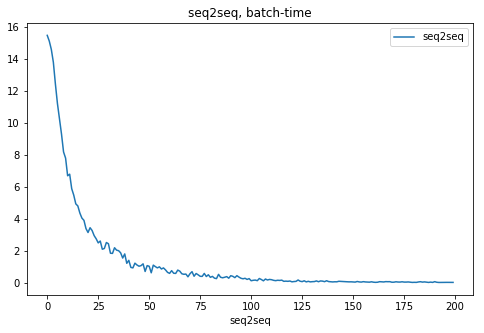

In [21]:
%matplotlib inline

import time
import pandas as pd
loss_tracks = dict()

tf.reset_default_graph()
with tf.Session() as sess:
    
    model = BasicS2SModel(vocab=vocab,num_layers=3)
    
    sess.run(tf.global_variables_initializer())
    print("start to run")
    loss_history = []
    t0 = time.time()
    for epoch in range(100):
        all_preds = []
        epoch_loss = 0
        for input_batch, target_batch in zip(input_batches, target_batches):
            input_batch_tokens = []
            target_batch_tokens = []
            enc_sentence_lengths = []
            dec_sentence_lengths = []

            for input_sent in input_batch:
                tokens, sent_len = sent2idx(input_sent)
                input_batch_tokens.append(tokens)
                enc_sentence_lengths.append(sent_len)

            for target_sent in target_batch:
                tokens, sent_len = sent2idx(target_sent,
                             vocab=vocab,
                             max_sentence_length=dec_sentence_length,
                             is_target=True)
                target_batch_tokens.append(tokens)
                dec_sentence_lengths.append(sent_len)
            batch_preds, batch_loss = model.train_one_step(sess,input_batch_tokens,enc_sentence_lengths,target_batch_tokens,dec_sentence_lengths)
            epoch_loss += batch_loss
            #loss_history.append(batch_loss)
            all_preds.append(batch_preds)
        loss_history.append(epoch_loss)
        if epoch % 20 == 0:
            print('Epoch', epoch)
            print('epoch loss: ', epoch_loss )
            for input_sent, target_sent, pred in zip(input_batch, target_batch, batch_preds):
                print('Input:', input_sent)
                print('Prediction:', idx2sent(pred, reverse_vocab=reverse_vocab))
                print('Target:', target_sent)
    
    writer = tf.summary.FileWriter('/tmp/test_s2s/', sess.graph)
    saver = tf.train.Saver(tf.global_variables())
    saver.save(sess,"/tmp/test_s2s/model.ckpt",global_step=model.global_step)

    loss_took = time.time() - t0
    s2s_track = pd.Series(loss_history, name='seq2seq')
    tracks_batch = pd.DataFrame(dict(seq2seq=s2s_track))
    tracks_batch.index.name = 'seq2seq'
    s2s_track.index = s2s_track.index / loss_took
    tracks_time = pd.DataFrame(dict(seq2seq=s2s_track)).ffill()
    tracks_time.index.name = 'time (seconds)'
    tracks_batch.plot(figsize=(8, 5), title='seq2seq, batch-time')
    

In [20]:
print (loss_history)

[15.486562252044678, 15.123505592346191, 14.678908586502075, 13.772567987442017, 12.345755100250244, 10.97653603553772, 10.495442867279053, 9.550214767456055, 8.946672558784485, 8.419196963310242, 7.716691374778748, 7.2025076150894165, 6.599082708358765, 6.114375174045563, 5.523699223995209, 5.382454574108124, 4.995788037776947, 4.3417728543281555, 4.113262444734573, 4.027514338493347, 3.7346969544887543, 3.2995285391807556, 3.5986821055412292, 3.112831473350525, 2.938249886035919, 2.6047632843255997, 2.32041996717453, 2.1969920694828033, 2.1852485835552216, 2.0100411027669907, 2.407414436340332, 1.6765832006931305, 1.9437263160943985, 2.166881948709488, 1.8001075685024261, 1.5403891950845718, 1.974030241370201, 1.2697069346904755, 1.2554083466529846, 1.3617087751626968, 1.267273798584938, 1.163369357585907, 1.1158602386713028, 1.0883061066269875, 0.9849008452147245, 0.8753483239561319, 1.1134662628173828, 1.056170329451561, 1.0251830257475376, 1.1948361806571484, 0.8479281365871429, 0

## Inference

####  Gready search

In [9]:
tf.reset_default_graph()
with tf.Session() as sess:
    model = BasicS2SModel(vocab=vocab,mode="inference",use_beam_search=False,num_layers=3)
    saver = tf.train.Saver(tf.global_variables())
    saver.restore(sess,tf.train.latest_checkpoint('/tmp/test_s2s/'))
    batch_preds = []
    batch_tokens = []
    batch_sent_lens = []

    for input_sent in input_batches[1]:
        tokens, sent_len = sent2idx(input_sent)
        batch_tokens.append(tokens)
        batch_sent_lens.append(sent_len)

    batch_preds = model.inference(sess,batch_tokens,batch_sent_lens)

    for input_sent, target_sent, pred in zip(input_batches[1], target_batches[1], batch_preds[0]):
        print('Input:', input_sent)
        print(pred)
        print('Prediction:', idx2sent(pred, reverse_vocab=reverse_vocab))
        print('Target:', target_sent)

(AttentionWrapperState(cell_state=<tf.Tensor 'S2S/bi_convert/BiasAdd/Identity:0' shape=(?, 128) dtype=float32>, attention=<tf.Tensor 'S2S/AttentionWrapperZeroState/zeros_2/Identity:0' shape=(?, 30) dtype=float32>, time=<tf.Tensor 'S2S/AttentionWrapperZeroState/zeros_1:0' shape=() dtype=int32>, alignments=<tf.Tensor 'S2S/AttentionWrapperZeroState/zeros/Identity:0' shape=(?, ?) dtype=float32>, alignment_history=(), attention_state=<tf.Tensor 'S2S/AttentionWrapperZeroState/zeros_3/Identity:0' shape=(?, ?) dtype=float32>), <tf.Tensor 'S2S/bi_convert/BiasAdd:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'S2S/bi_convert/BiasAdd:0' shape=(?, 128) dtype=float32>)
INFO:tensorflow:Restoring parameters from /tmp/test_s2s/model.ckpt-400
('Input:', 'Which programming language do you use?')
[ 0 12 38 30  3  3  3  3  3  3]
('Prediction:', '_GO_ I like Python . . . . . .')
('Target:', 'I like Python.')
('Input:', 'See you later.')
[ 0 13 13  3  3  3  3  3  3  3]
('Prediction:', '_GO_ Bye Bye . . . . . 

####  Beam search

> Beam search results are not good, need to take a deep look into the implementation, suggested not to use it right now.

In [10]:
tf.reset_default_graph()
with tf.Session() as sess:
    model = BasicS2SModel(vocab=vocab,mode="inference",use_beam_search=True,beam_size=3,num_layers=3)
    saver = tf.train.Saver(tf.global_variables())
    saver.restore(sess,tf.train.latest_checkpoint('/tmp/test_s2s/'))
    batch_preds = []
    batch_tokens = []
    batch_sent_lens = []

    for input_sent in input_batches[3]:
        tokens, sent_len = sent2idx(input_sent)
        batch_tokens.append(tokens)
        batch_sent_lens.append(sent_len)
    batch_preds,ids = model.inference(sess,batch_tokens,batch_sent_lens)
    for input_sent, target_sent, pred in zip(input_batches[3], target_batches[3], batch_preds):
        print('Input:', input_sent)
        for p in pred:
            print('Prediction:', idx2sent(p, reverse_vocab=reverse_vocab))
        print('Target:', target_sent)

(AttentionWrapperState(cell_state=<tf.Tensor 'S2S/tile_batch_2/Reshape:0' shape=(6, 128) dtype=float32>, attention=<tf.Tensor 'S2S/AttentionWrapperZeroState/zeros_2:0' shape=(6, 30) dtype=float32>, time=<tf.Tensor 'S2S/AttentionWrapperZeroState/zeros_1:0' shape=() dtype=int32>, alignments=<tf.Tensor 'S2S/AttentionWrapperZeroState/zeros:0' shape=(6, 10) dtype=float32>, alignment_history=(), attention_state=<tf.Tensor 'S2S/AttentionWrapperZeroState/zeros_3:0' shape=(6, 10) dtype=float32>), <tf.Tensor 'S2S/tile_batch_2/Reshape:0' shape=(6, 128) dtype=float32>, <tf.Tensor 'S2S/tile_batch_2/Reshape:0' shape=(6, 128) dtype=float32>)
INFO:tensorflow:Restoring parameters from /tmp/test_s2s/model.ckpt-400
('Input:', 'What do you want to drink?')
('Prediction:', '_GO_ Beer please ! ! ! ! ! . .')
('Prediction:', '_GO_ Beer please ! ! ! ! ! ! .')
('Prediction:', '_GO_ Beer please ! ! ! ! . . .')
('Target:', 'Beer please!')
('Input:', 'What is your favorite beer?')
('Prediction:', '_GO_ Leffe brown